# All

In [2]:
# Import libraries
import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import requests

# Import necessary libraries
import sys
sys.path.append('/content/Requied_Files/Requied_Files/')
import torch
import torchvision
import utils
import re
import pascal_dataset, engine, coco_eval, coco_utils, transforms, utils
import torch.utils.data
import torchvision.transforms as T
from engine import train_one_epoch, evaluate
from pascal_dataset import PASCALDataset
from torch.utils.data import DataLoader
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
from coco_eval import CocoEvaluator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import shutil
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random


In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
# Unzip the dataset
import zipfile

with zipfile.ZipFile('PASCAL.zip', 'r') as zip_ref:
    zip_ref.extractall('PASCAL')


  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
From (redirected): https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai&confirm=t&uuid=8863c1f0-1055-4f30-a9c1-294dc05933b9
To: /content/PASCAL.zip
100% 116M/116M [00:02<00:00, 40.4MB/s]


In [4]:
# Import the PASCALDataset class
from pascal_dataset import PASCALDataset

# Define the path to your custom dataset
path_to_data_test = '/content/PASCAL/PASCAL/test'

# Create an instance of the dataset
dataset_test = PASCALDataset(path_to_data_test)

# Define the path to your custom dataset
path_to_data_train = '/content/PASCAL/PASCAL/train'

# Create an instance of the dataset
dataset_train = PASCALDataset(path_to_data_train)

# Define the path to your custom dataset
path_to_data_val = '/content/PASCAL/PASCAL/val'

# Create an instance of the dataset
dataset_val = PASCALDataset(path_to_data_val)

In [5]:
# Define classes list
classes = [
    "__background__",  # 0 index
    "person",
    "bicycle",
    "car",
    "motorbike",
    "aeroplane",
    "bus",
    "bird",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "boat",
    "bottle",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

# Define bbox colors for each class
colors = {
    "person": "red",
    "bicycle": "green",
    "car": "blue",
    "motorbike": "yellow",
    "aeroplane": "cyan",
    "bus": "magenta",
    "bird": "orange",
    "cat": "purple",
    "chair": "brown",
    "cow": "pink",
    "diningtable": "gray",
    "dog": "olive",
    "horse": "teal",
    "boat": "navy",
    "bottle": "maroon",
    "pottedplant": "coral",
    "sheep": "gold",
    "sofa": "lime",
    "train": "indigo",
    "tvmonitor": "darkorange"
}

In [6]:
# create data loader objects for training, validation, and testing sets
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4,  collate_fn=utils.collate_fn)

In [7]:

# create an object of the Faster R-CNN model with ResNet50 as backbone and load pretrained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 75.6MB/s]


In [8]:

# create an optimizer object with stochastic gradient descent (SGD) algorithm
# and set learning rate, momentum, and weight decay values
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
import torch
from pascal_dataset import PASCALDataset
import utils

# Create instances of PASCALDataset for training and validation datasets
train_dataset = PASCALDataset('/content/PASCAL/PASCAL/train')
val_dataset = PASCALDataset('/content/PASCAL/PASCAL/val')

# Create data loaders for the training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# Define number of epochs and frequency of status updates during training
epoch = 5
print_freq = 25

# Train and validate the model for the specified number of epochs
for epoch in range(epoch):
    # Train the model for one epoch using the train_loader
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq, scaler=None)

    # Evaluate the model using the val_loader
    evaluate(model, val_loader, device)

Epoch: [0]  [  0/251]  eta: 0:46:44  lr: 0.000005  loss: 0.1230 (0.1230)  loss_classifier: 0.0511 (0.0511)  loss_box_reg: 0.0472 (0.0472)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0208 (0.0208)  time: 11.1743  data: 0.3265  max mem: 6469
Epoch: [0]  [ 25/251]  eta: 0:06:18  lr: 0.000105  loss: 0.1854 (0.1950)  loss_classifier: 0.0778 (0.0837)  loss_box_reg: 0.0904 (0.0882)  loss_objectness: 0.0056 (0.0078)  loss_rpn_box_reg: 0.0081 (0.0153)  time: 1.2947  data: 0.0149  max mem: 7646
Epoch: [0]  [ 50/251]  eta: 0:04:58  lr: 0.000205  loss: 0.2055 (0.2091)  loss_classifier: 0.0710 (0.0832)  loss_box_reg: 0.1011 (0.0991)  loss_objectness: 0.0051 (0.0100)  loss_rpn_box_reg: 0.0178 (0.0168)  time: 1.2592  data: 0.0177  max mem: 7646
Epoch: [0]  [ 75/251]  eta: 0:04:14  lr: 0.000305  loss: 0.2000 (0.2166)  loss_classifier: 0.0750 (0.0852)  loss_box_reg: 0.0984 (0.1058)  loss_objectness: 0.0057 (0.0096)  loss_rpn_box_reg: 0.0112 (0.0160)  time: 1.3784  data: 0.0149  max mem: 7646

In [12]:
import torch
import shutil

# Save the state dictionary of the trained model as a file named 'model1.pth'
torch.save(model.state_dict(), 'model1.pth')

# # Copy the saved model file from its current location to Google Drive
# shutil.copyfile('/content/model1.pth', '/content//model1.pth')

SameFileError: ignored

In [ ]:
_get_iou_types(model)


In [13]:
for images, targets in data_loader_test:
    # Move images to the specified device (e.g. GPU) for faster computation
    images = list(image.to(device) for image in images)

    # Move target annotations to the same device
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Forward pass of the model to obtain the loss dictionary
    loss_dict = model(images, targets)

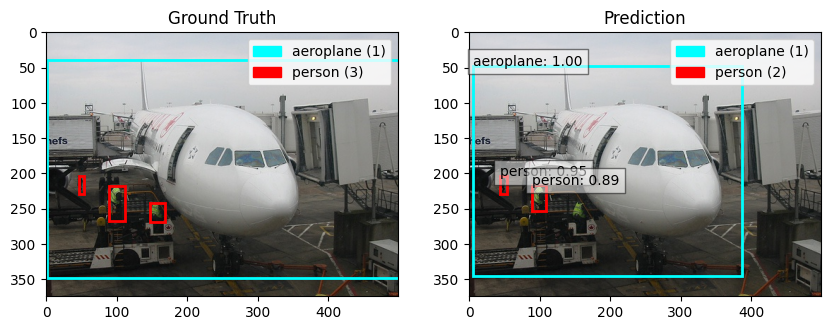

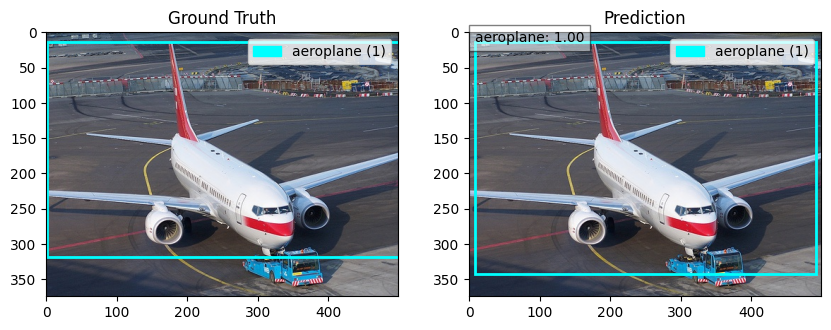

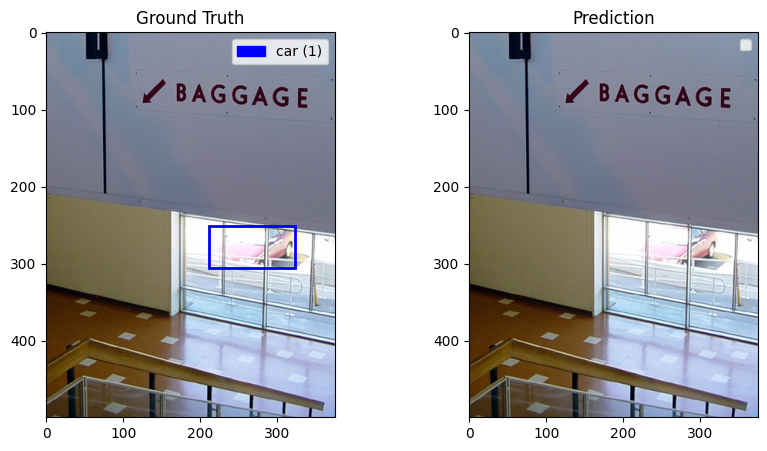

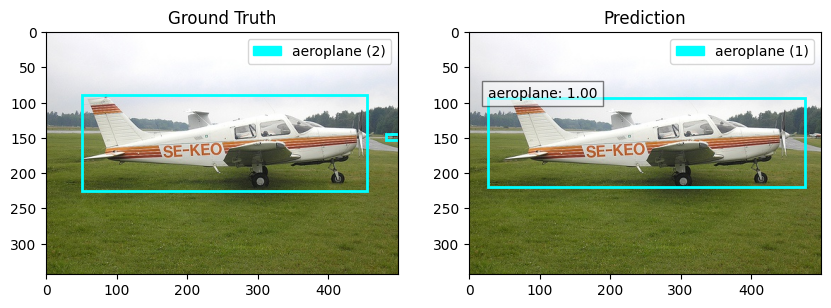

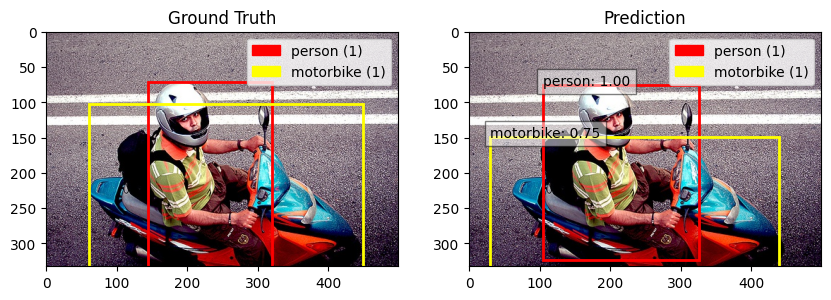

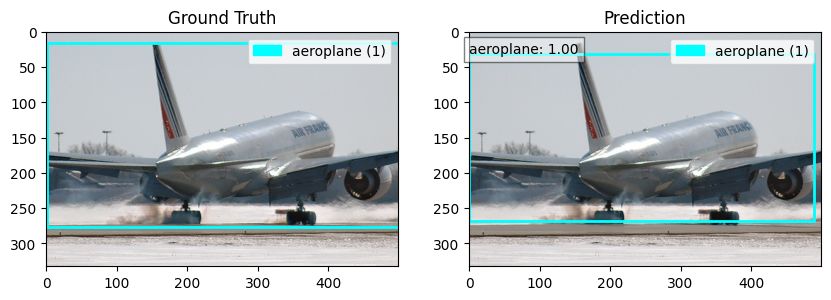

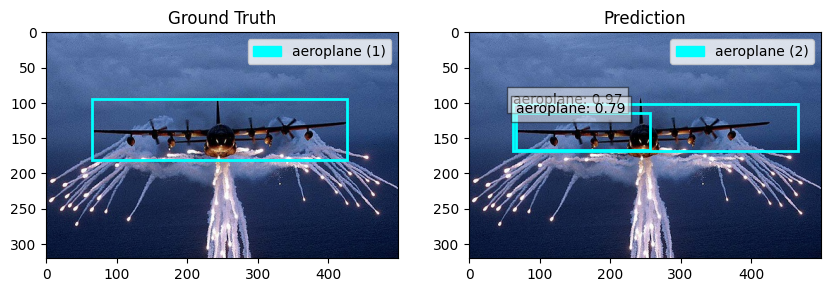

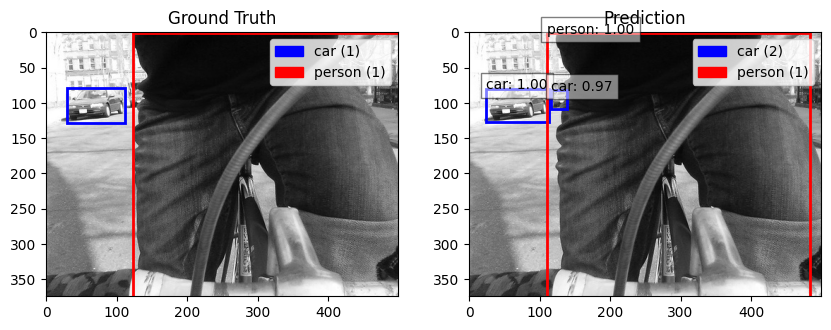

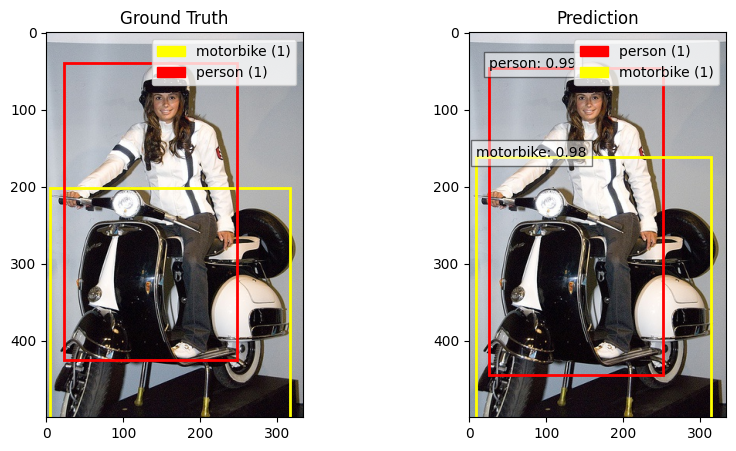

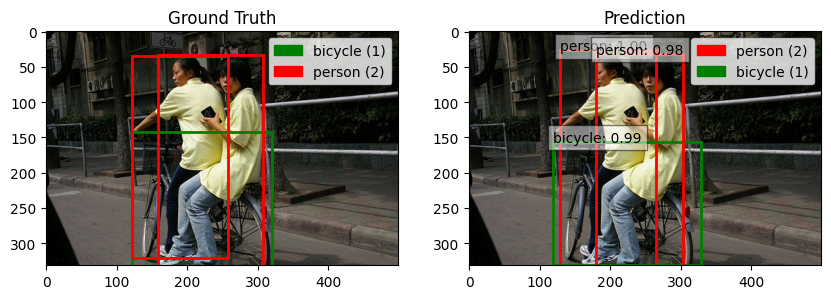

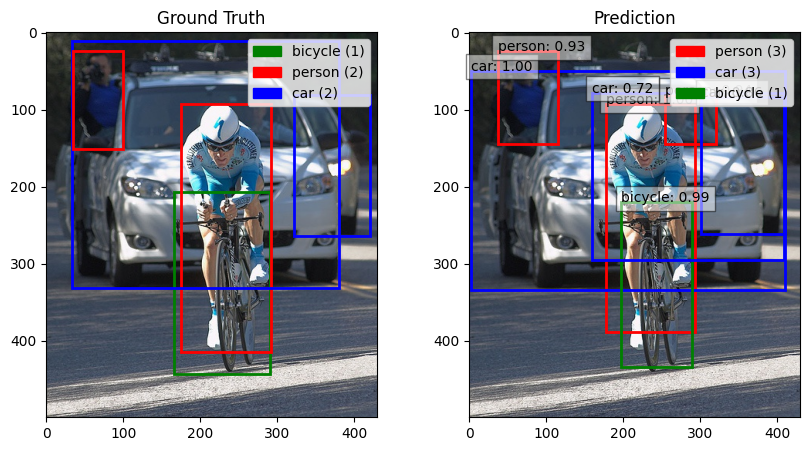

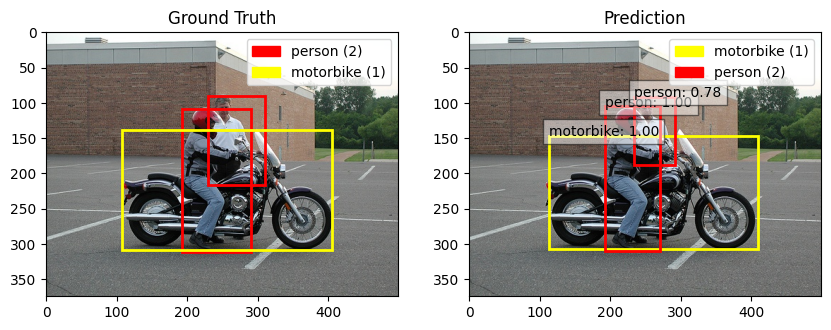

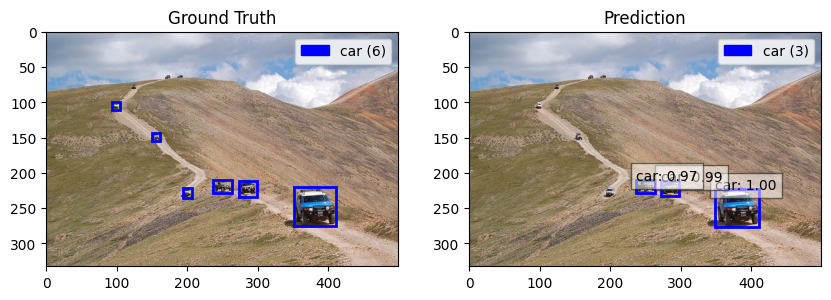

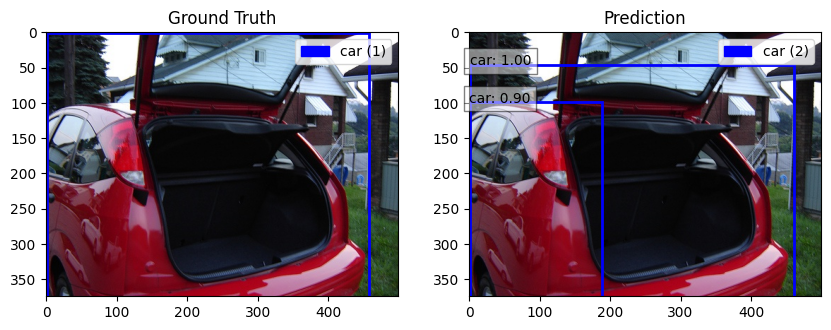

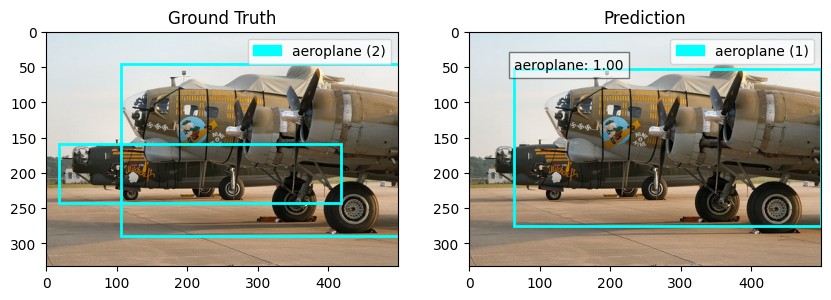

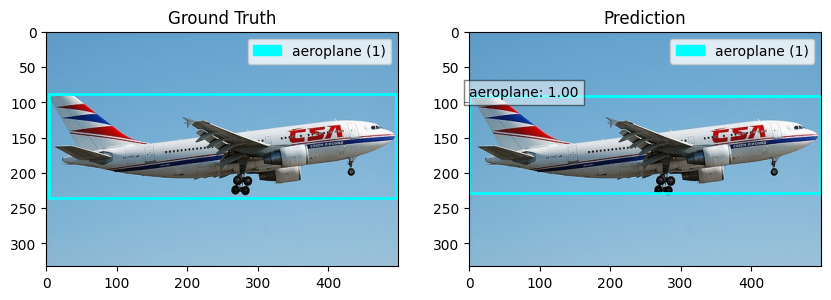

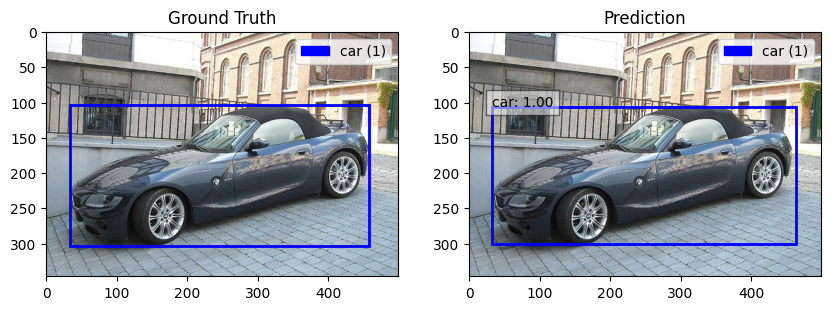

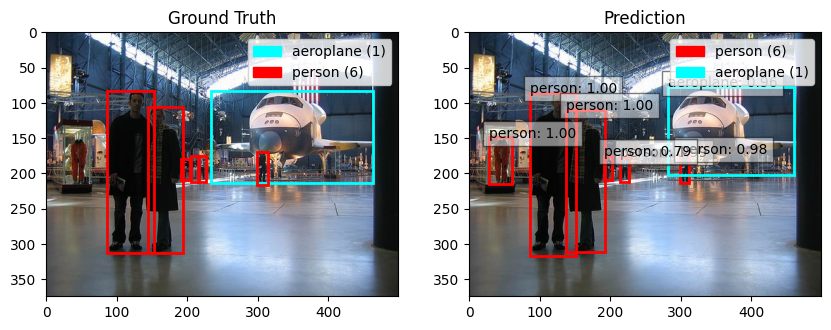

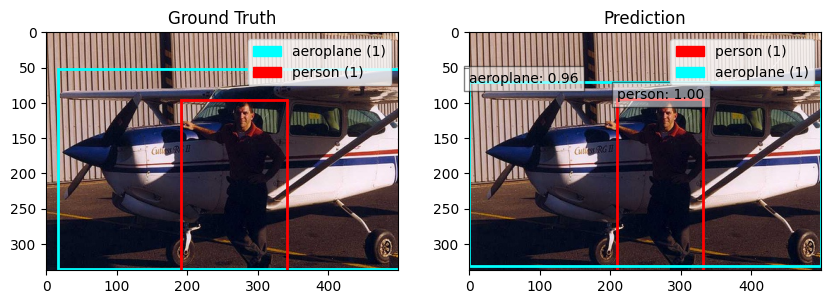

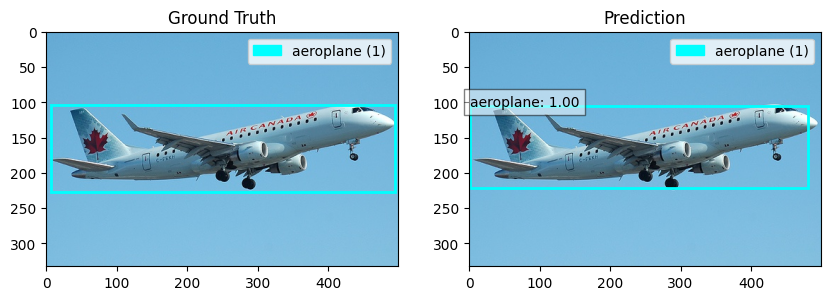

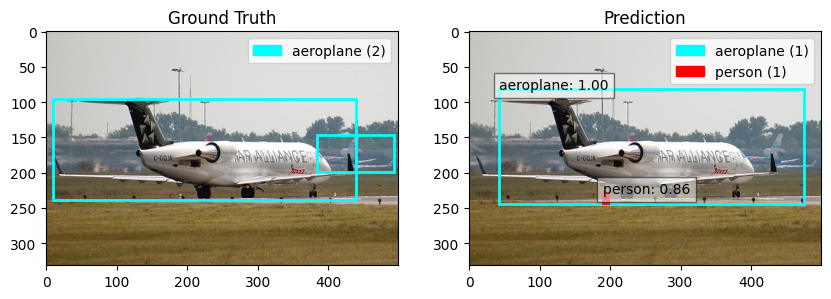

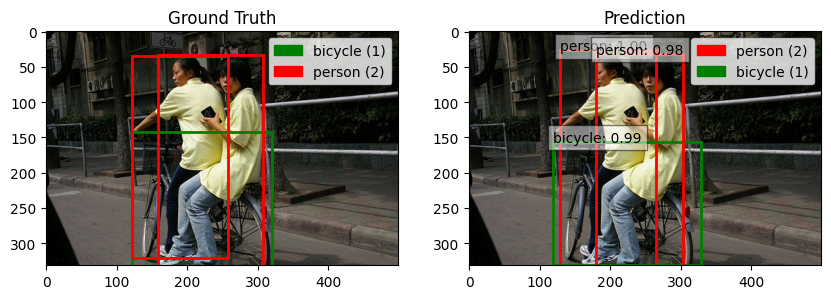

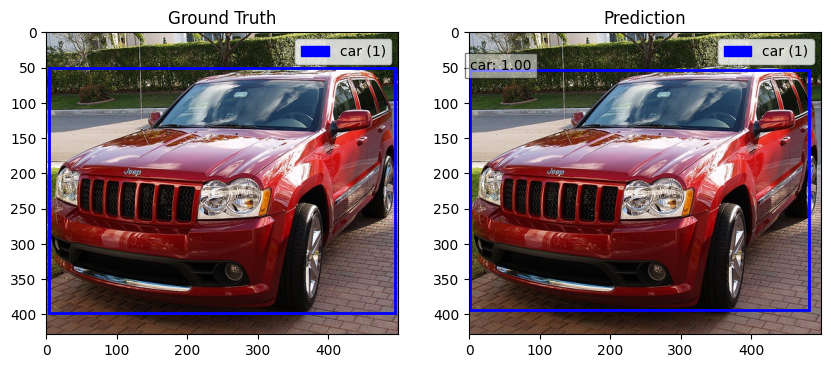

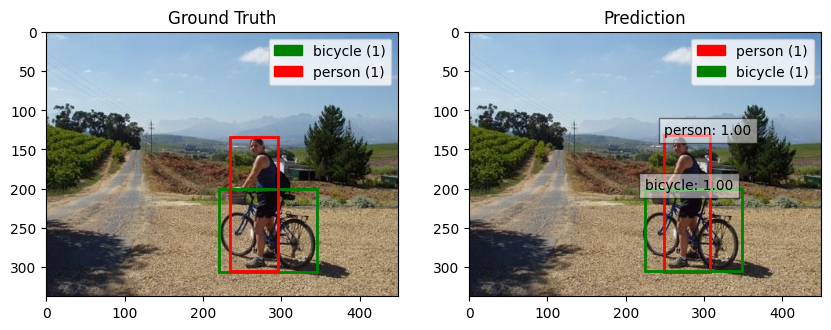

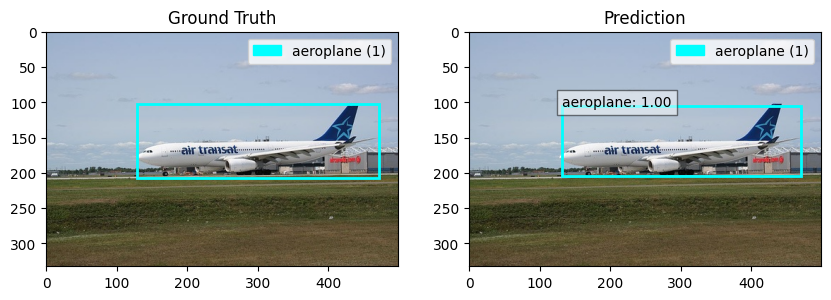

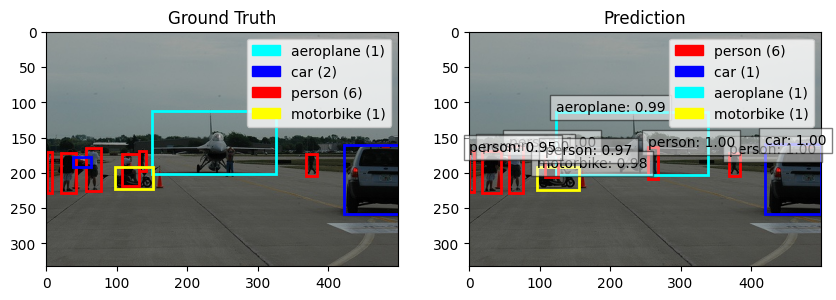

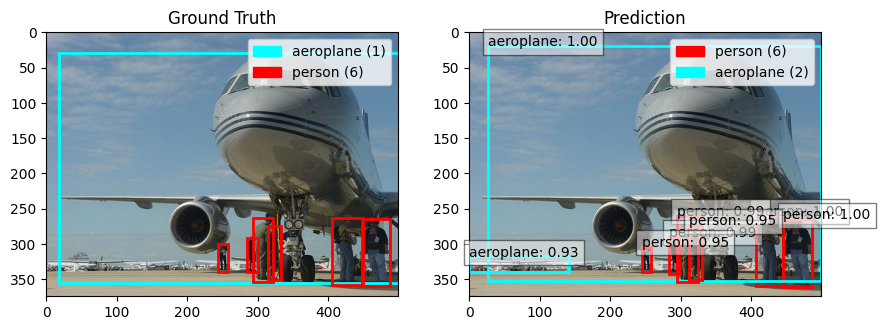

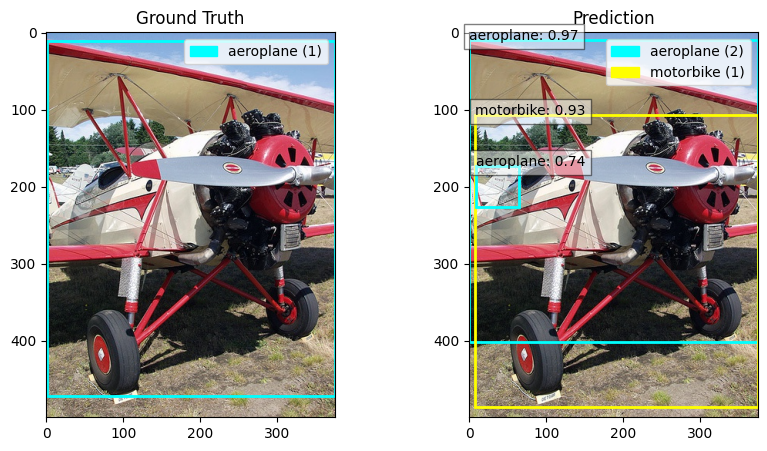

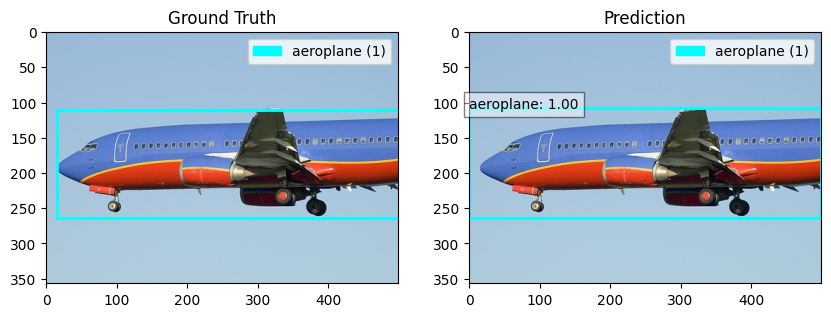

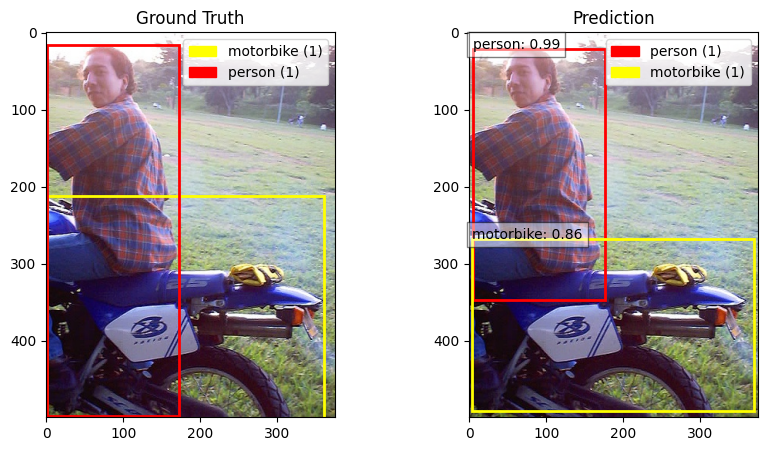

In [25]:

def plot_image_with_bboxes(image, targets, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0))
    ax2.imshow(image.permute(1, 2, 0))
    ax1.set_title('Ground Truth')
    ax2.set_title('Prediction')

    # Plot ground truth
    gt_boxes = targets['boxes']
    gt_labels = targets['labels']
    gt_counts = dict()
    for box, label in zip(gt_boxes, gt_labels):
        x1, y1, x2, y2 = box.cpu().numpy()
        class_name = classes[label]
        edgecolor = colors[class_name]
        ax1.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=edgecolor, linewidth=2))
        if class_name not in gt_counts:
            gt_counts[class_name] = 1
        else:
            gt_counts[class_name] += 1
    # Add GT legend
    gt_legend = []
    for class_name, count in gt_counts.items():
        gt_legend.append(mpatches.Patch(color=colors[class_name], label=f'{class_name} ({count})'))
    # ax1.legend(handles=gt_legend, bbox_to_anchor=(0.5, -0.1), loc='right', ncol=len(gt_legend))
    ax1.legend(handles=gt_legend, loc='upper right')

    # Plot predictions
    pred_boxes = predictions['boxes']
    pred_labels = predictions['labels']
    pred_scores = predictions['scores']
    pred_counts = dict()
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score < 0.7:
            continue
        x1, y1, x2, y2 = box.cpu().numpy()
        class_name = classes[label]
        edgecolor = colors[class_name]
        ax2.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=edgecolor, linewidth=2))
        ax2.text(x1, y1, f'{class_name}: {score:.2f}', bbox=dict(facecolor='white', alpha=0.5))
        if class_name not in pred_counts:
            pred_counts[class_name] = 1
        else:
            pred_counts[class_name] += 1
    # Add Prediction legend
    pred_legend = []
    for class_name, count in pred_counts.items():
        pred_legend.append(mpatches.Patch(color=colors[class_name], label=f'{class_name} ({count})'))
    ax2.legend(handles=pred_legend, loc='upper right')

    plt.savefig('image_with_bboxes.pdf', bbox_inches='tight')
    plt.show()


# Evaluate on 3 random test images
for i in range(30):
    image, target = dataset_test[random.randint(0, len(dataset_test))]
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
    plot_image_with_bboxes(image, target, prediction)